## Прогнозирование уровня средней заработной платы в России


In [115]:
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from scipy.stats import boxcox
from itertools import product
import warnings

%matplotlib inline

In [13]:
salary_data = pd.read_csv('WAG_C_M.csv', ';', index_col=['month'], parse_dates=['month'],dayfirst=True)
salary_data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


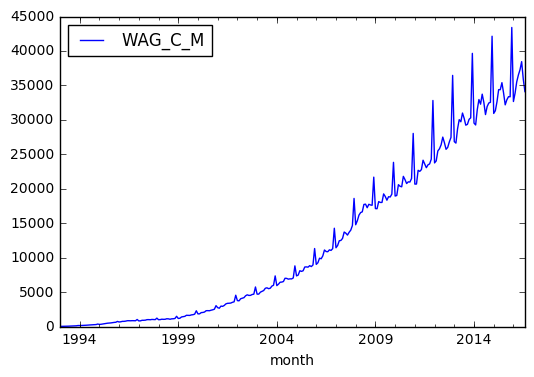

In [14]:
salary_data.plot()

Визуальный анализ: По графику видно, что ряд имеет тренд и сезонность. Также можно отметить, что дисперсия увеличивается с течением времени. Попробуем стабилизировать дисперсию. 

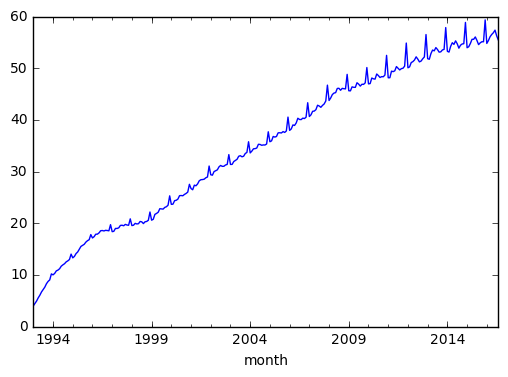

In [74]:
salary_data['wag_box'], lmbda = boxcox(salary_data['WAG_C_M'])
salary_data.wag_box.plot()

Теперь попробуем сделать ряд стационарным с помощью дифференцирования

p-value:  0.0143961521649
p-value:  0.0146971334948
p-value:  5.20360371582e-08


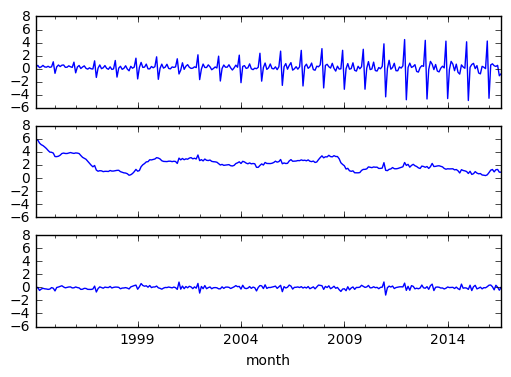

In [92]:
#обычное дифференцирование
sal_box_diff1 = salary_data['wag_box'] - salary_data['wag_box'].shift(1)
sal_box_diff1.dropna(inplace=True)
print 'p-value: ', sm.tsa.stattools.adfuller(sal_box_diff1)[1]

f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
sal_box_diff1.plot(ax=ax1)
# Сезонное дифференцирование
sal_box_diff12 = salary_data['wag_box']  - salary_data['wag_box'] .shift(12)
sal_box_diff12.dropna(inplace=True)
print 'p-value: ', sm.tsa.stattools.adfuller(sal_box_diff12)[1]

sal_box_diff12.plot(ax=ax2)
# и сезонное, и обычное дифференцирование
sal_box_diff13 = sal_box_diff12-sal_box_diff12.shift(1)
sal_box_diff13.dropna(inplace=True)
print 'p-value: ', sm.tsa.stattools.adfuller(sal_box_diff13)[1]
sal_box_diff13.plot(ax=ax3)

plt.show()

Для 3 вариантов дифференцирования p-value меньше чем 0.05, но исходя из графиков 3 преобразование больше 
всего похоже на стационарное.

Подбираем Q,q, P,p параметры, c помощью автокорреляционной и частично-автокорреляционной функциию

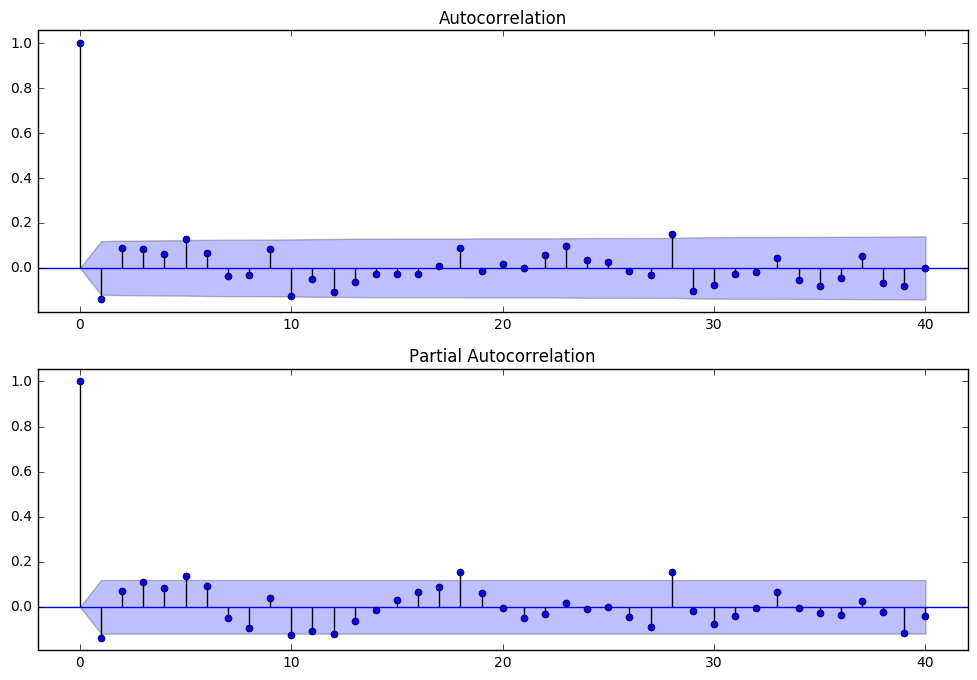

In [93]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sal_box_diff13.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sal_box_diff13, lags=40, ax=ax2)

Исходя из графиков выберем следуюющие первоначальные параметры: Q=0, q=5, P=1, p=5

In [94]:
ps = range(0, 6)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [97]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

72

In [116]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(sal_box_diff13, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

AttributeError: 'module' object has no attribute 'statespace'

In [114]:
!pip install -U statsmodels

Requirement already up-to-date: statsmodels in c:\users\aleh_darashenka\appdata\local\continuum\anaconda2\lib\site-packages


In [113]:
!pip install --upgrade pip

Requirement already up-to-date: pip in c:\users\aleh_darashenka\appdata\local\continuum\anaconda2\lib\site-packages
